# HCI 2017 Week 7 - Angular Differential Imaging
*Matthew Kenworthy // Leiden Observatory*

Today we cover the implementation of Angular Differential Imaging as described in [Marois et al. (2006)](http://adsabs.harvard.edu/abs/2006ApJ...641..556M). You should download the paper and keep a copy open - we'll use the same terminology.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

## Useful functions

In [2]:
def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    from astropy.io import fits
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, overwrite=True)

def r_theta(im, xc, yc):
    # returns the radius rr and the angle phi for point (xc,yc)
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

def zoom(im,x,y,bb):
    '''returns a square 2D image cut out from im centered on location (x,y) and with half-width bb'''
    return(im[y-bb:y+bb,x-bb:x+bb])

def rings(im, x, y, r_rings):
    # makes a mask for rings of different radii specified in r_rings
    # and centre (x,y)
    # invalid values are -1
    # first, second, third... ring has value (0, 1, 2, ....)
    # ring 0 is from r_rings[0] to r_rings[1]
    # ring 1 is from r_rings[1] to r_rings[2]
    im_rings = np.zeros_like(im) - 1.
    
    # make r_inner and r_outer
    r_inner = r_rings[0:-1]
    r_outer = r_rings[1:]
    
    r, t = r_theta(im_rings, x, y)
    for i, (rin, rout) in enumerate(zip(r_inner,r_outer)):
        im_rings[(r >= rin) * (r < rout)] = i


    r_middle = (r_inner + r_outer) / 2.
    return(im_rings, r_middle)

## Data of the planetary system HR 8799

The data is from the [NIRC2](https://www2.keck.hawaii.edu/inst/nirc2/) camera on the Keck II 10m telescope, from observing program U159N2 by Bruce Macintosh. This data is courtesy of Travis Barman. Image registration by Raphael Galicher. 

The data is taken in the L prime (Lp) filter (covers 3.42 to 4.12 microns in wavelength), in the narrow camera pixel scale (10mas/pixel)

https://www2.keck.hawaii.edu/inst/nirc2/genspecs.html

## Image data and position angle data
The data is approximately 100 images taken over the course of one night on Keck in 2009. Keck is an Alt-az telescope, so the sky rotates in the camera field of view. To derotate the images so that they are all aligned on the sky, you need a list of derotation angles, provided in `rotnth.fits`. You can read it in the same way as the data cube file.

**Q1 (2 points): ** Read in the rotation angle file and plot it using `plot` and label the x axis with 'frame number' and y label with 'rotation angle'.

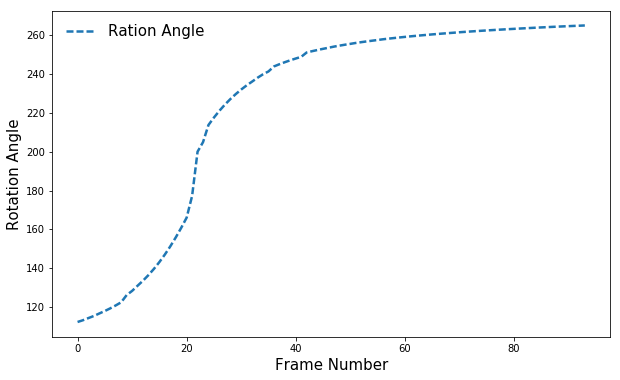

In [3]:
Rot, Head_1 = fits.getdata('barman_2009_data/rotnth.fits', header = True)
#print(Rot.shape)

plt.figure(figsize = (10,6))
plt.plot(Rot, '--', lw = 2.5, label = 'Ration Angle')
plt.xlabel("Frame Number", size = 15)
plt.ylabel("Rotation Angle", size = 15)
plt.legend(frameon = False, prop = {'size': 15})

## Subtract off the sky background

Bad/missing values are labelled as `NaN` in `FITS` files and in `numpy`. You must use `np.nanmedian()` and `np.nansum()` and other `np.nan....` functions to correctly account for the `NaN` values in the data.

For all the `np.sum`, `np.median` functions, you can also specify one or more axes to carry out a median or sum over, and you can specify them as an option like `axis=(1,3)` to carry out the function over both the 1 and 3 dimesions.

The sky background varies by several thousand counts between frames, but it can be treated as a constant value across the whole frame. Well over half of the pixels in each frame have sky in them, so taking a median of each frame is a good approximation for the sky background.


**Q2 (3 points): ** Calculate the median of all the frames, and plot it. Then subtract off the median of each individual image from itself, and call this `im_bg`.

Additionally, set all the `NaN` values to zero by using `np.nan_to_num()`

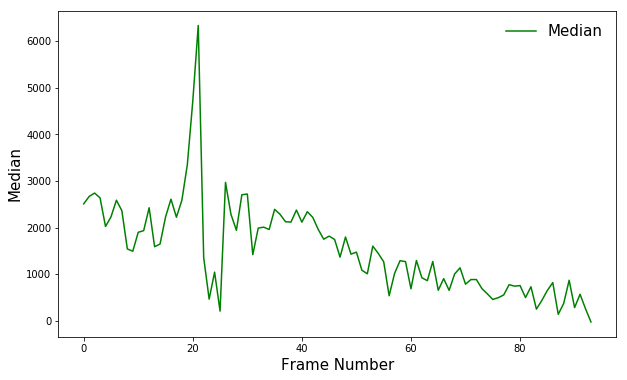

In [4]:
# Q2 answer here
Center, Head_2 = fits.getdata('barman_2009_data/center_im.fits', header = True)
#Center.shape
#Median = np.nanmedian(Center, 0)
#Median.shape
Median = np.nanmedian(Center, axis = (1, 2))

plt.figure(figsize = (10,6))
plt.plot(Median, color = 'g', label = 'Median')
plt.xlabel("Frame Number", size = 15)
plt.ylabel("Median", size = 15)  
plt.legend(frameon = False, prop = {'size': 15})

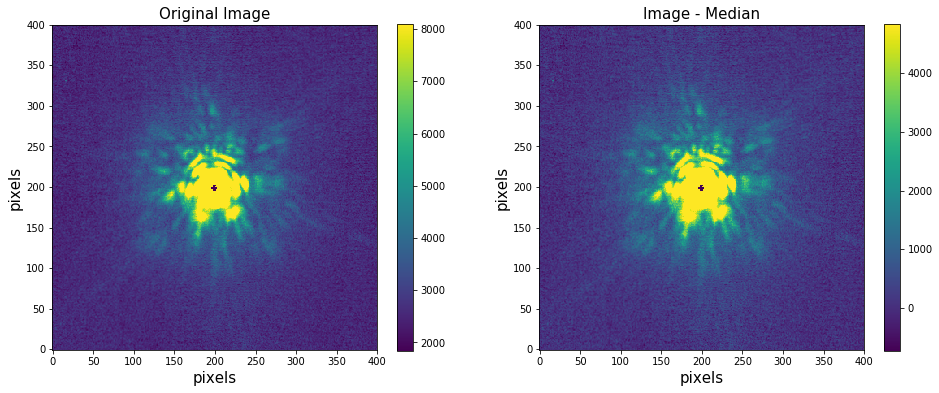

In [5]:
im_bg = []
for i in range(94):
    #NAN_to_Zero       = np.nan_to_num(Center[i])
    im_bg.append( np.nan_to_num( Center[i] - Median[i]) )    
    
im_bg = np.array(im_bg)   

#wfits(im_bg, 'im_bg.fits')

fig, ((axA, axB)) = plt.subplots(figsize = (16, 6), nrows = 1, ncols = 2)

A = axA.imshow(zoom(Center[0], 611, 611, 200), vmin = 1845.71, vmax = 8089.33, interpolation = 'none')
axA.set_xlabel('pixels', size = 15)
axA.set_ylabel('pixels', size = 15)
axA.set_title('Original Image', size = 15)
plt.colorbar(A, ax = axA)

B = axB.imshow(zoom(im_bg[0], 611, 611, 200), vmin = -726.803, vmax = 4831.05, interpolation = 'none') 
axB.set_xlabel('pixels', size = 15)
axB.set_ylabel('pixels', size = 15)
axB.set_title('Image - Median', size = 15)
plt.colorbar(B, ax = axB)

In [6]:
def cen_rot2 (im, rot, dim_out, offset1=(0,0), offset2=(0,0), order=2):
    """cen_rot2 - takes a cube of images im, and a set of rotation angles in rot,
                and translates the middle of the frame with a size dim_out to the middle of
                a new output frame with an additional rotation of rot.
                """
    from scipy.ndimage import affine_transform
    a = rot * np.pi / 180.
    
    # make a rotation matrix
    transform=np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    
    # calculate total offset for image output

    # determine centre of input image

    # -0.5 is there for fencepost counting error
    c_in = np.array(offset1) - 0.5
    c_out = 0.5 * np.array(dim_out) - 0.5

    # c_out has to be pre-rotated to make offset correct
    offset = c_in - c_out.dot(transform) - np.array(offset2).dot(transform)
    
    # perform the transformation
    dst=affine_transform( \
        im,transform.T, order=order,offset=offset, \
        output_shape=dim_out, cval=0.0)
    return(dst)

## Testing `cen_rot2`
Make a random small image, then put it into a larger image with a rotation of 30 degrees, to convince yourself you understand how the rotation and translation works in `cen_rot2()`

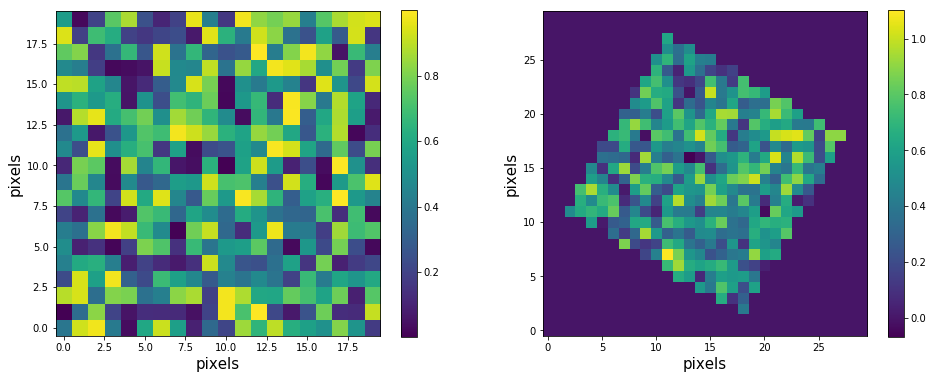

In [7]:
# test code for cen_rot2 here

fig, ((axA, axB)) = plt.subplots(figsize = (16, 6), nrows = 1, ncols = 2)


Random_im = np.random.random((20, 20))
A = axA.imshow(Random_im)
axA.set_xlabel('pixels', size = 15)
axA.set_ylabel('pixels', size = 15)
plt.colorbar(A, ax = axA)

New_im = cen_rot2 (Random_im, 30, (30, 30), (10, 10))
B = axB.imshow(New_im)
axB.set_xlabel('pixels', size = 15)
axB.set_ylabel('pixels', size = 15)
plt.colorbar(B, ax = axB)

In [8]:
def derot(imin, rotangle, out_dims, star_cen):
    # get shape of input image
    nim, nx, ny = imin.shape

    # make a zero value numpy array for the output
    im_out = np.zeros((nim, out_dims[0], out_dims[1]))
    
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = cen_rot2(frame_sq, rotangle[j], out_dims, offset1=star_cen)
        im_out[j,:,:] = frame_rot
        
    return(im_out)    

## Derotating the image cube to align with the sky

You can use `derot(im, rot, (nx, ny), (sx, sy))` to produce a cube of images that are `(nx, ny)` in size with the correct derotation to align the sky. 

**Q3 (1 point)** Determine the centroid of the star `sx, sy` to the nearest pixel in the data cube by visual inspection. Write out the derotated cube to `out.fits` and use `ds9` to confirm that the PSF is rotating. Use `wfits(cube, fname)` to write out the cube.

In [9]:
# Q3 answer here
#plt.figure()
#plt.imshow(im_bg[0])
X = 611 #Center in px for the star
Y = 611 #Center in px for the star

Derot = derot(im_bg, Rot, (800, 800), (X, Y))
wfits(Derot, 'Derot.fits')
#plt.figure()
#plt.imshow(Derot[0])

## Subtract off the median from all frames then derotate and median

**Q4 (4 points): **
`im_bg` has zeroes for the `NaN` values so we can use that safely. Take the median of `im_bg` to estimate the telescope PSF, then subtract it off all individual images, then derotate the image cube, then take the median of that data cube and write it out to `med_sub.fits`. Examine it with `ds9` and see how many planets you can see.


In [10]:
# Q4 answer here

Median_2 = np.median(im_bg, axis = 0)

New = np.array(im_bg - Median_2)

Derot_2        = derot(New, Rot, (1224, 1224), (X, Y))
#Derot_2        = derot(New, Rot, (2000, 2000), (X, Y))
Median_Derot_2 = np.median(Derot_2, axis = 0 )
wfits(Median_Derot_2, 'med_sub_1.fits')

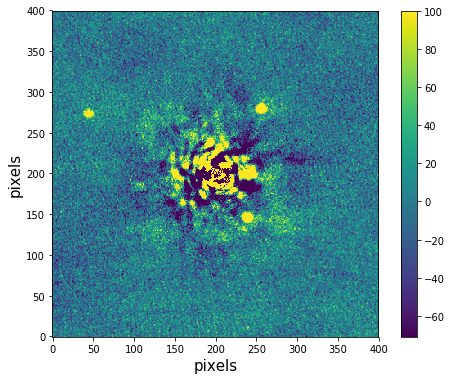

In [11]:
plt.figure(figsize = (8,6))
plt.imshow(zoom(Median_Derot_2, 611, 611, 200), vmin = -70.94, vmax = 100, interpolation = 'none')
plt.xlabel('pixels', size = 15)
plt.ylabel('pixels', size = 15)
plt.colorbar()

#There are three planets 

## Implementing ADI on the Keck data set

** Q5 (10 points): ** Today you will implement ADI using the Marois paper as guidance.

You will need to make three nested `for` loops:

1. looping over individual frames
2. looping over different annuli on which to carry out the ADI frame selection
3. looking over different values of `a` (Equation 8 in Marois 2006) to determine the best value to minimise the R.M.S.


In [12]:
# Q5 answer here

IM = New                                  #Image median subtracted

nim, nx, ny = IM.shape
I_ADI       = np.zeros_like(IM)

nwid     = 1.5
r, the   = r_theta(IM[0,:,:], 611, 611)
pscale   = 0.01                           #10 miliarsecs/px
r_arcsec = r * pscale

r_ring = np.linspace(0.2, 4.0, 21)
n_ring = r_ring.size - 1

r_adi = r_ring[:-1]

coeff_a = np.zeros((n_ring, nim))

FWHM = 3 * pscale

min_ang = np.rad2deg(np.arcsin(0.5 * nwid * FWHM / r_adi))

aArray = np.linspace(0, 1, 10 + 1, endpoint = True)

In [13]:
for i_frame, frame in enumerate(np.split(IM, nim, axis = 0)):
    
    frame = np.squeeze(frame)

    rotRelative = np.array(Rot - Rot[i_frame])
    
    imageIndicesLower  = np.arange(0, i_frame + 1)[::-1]
    imageIndicesHigher = np.arange(i_frame, nim)
   
    for j, min_ang_now, rmin, rmax in zip(np.arange(n_ring), min_ang, r_ring[:-1], r_ring[1:]):
        
        for iL in imageIndicesLower:
            if (rotRelative[iL] < -min_ang_now):
                break
        for iH in imageIndicesHigher:
            if (rotRelative[iH] > min_ang_now):
                break
               
        indexLowest  = max(iL - 1, 0)
        indexHighest = min(iH + 1, nim - 1)
        
        
        imRefMedian = np.median((IM[indexLowest,::], IM[iL,::], IM[iH,::], IM[indexHighest,::]), axis = 0)
        
        maskAnnulusInner = (r_arcsec > r_ring[j]) 
        maskAnnulusOuter = (r_arcsec < r_ring[j + 1]) 
        maskAnnulus = (maskAnnulusInner * maskAnnulusOuter)
                
        RMSBest = None
        aBest = None
        for a in aArray:
            imRefMedianSubtracted = IM[i_frame,::] - a * imRefMedian
            
            RMS = np.std(imRefMedianSubtracted[maskAnnulus])
            
            if (RMSBest == None):
                RMSBest = RMS
                aBest = a
            elif (RMS < RMSBest):
                RMSBest = RMS
                aBest = a
        
        I_ADI[i_frame,::][maskAnnulus] = (aBest * imRefMedian[maskAnnulus])
        coeff_a[j, i_frame] = aBest  

## Writing out the ADI image

**Q6 (2 points):** Derotate the ADI image cube to the sky coordinates and median it together, and write it out to `ADI.fits`

In [14]:
# Q6 answer here
IM_ADI = np.array(IM - I_ADI)

im_ADI = derot(IM_ADI, Rot, (1224, 1224), (X, Y))
im_ADI_median = np.median(im_ADI, axis = 0)
wfits(im_ADI_median, "ADI.fits")

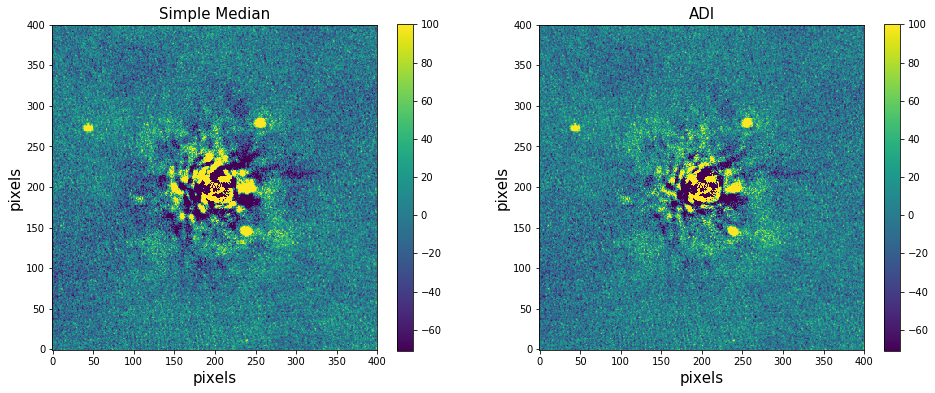

In [15]:
fig, ((axA, axB)) = plt.subplots(figsize = (16, 6), nrows = 1, ncols = 2)

A = axA.imshow(zoom(Median_Derot_2, 611, 611, 200), vmin = -70.94, vmax = 100, interpolation = 'none')
axA.set_xlabel('pixels', size = 15)
axA.set_ylabel('pixels', size = 15)
axA.set_title('Simple Median', size = 15)
plt.colorbar(A, ax = axA)

B = plt.imshow(zoom(im_ADI_median, 611, 611, 200), vmin = -70.94, vmax = 100, interpolation = 'none')
axB.set_xlabel('pixels', size = 15)
axB.set_ylabel('pixels', size = 15)
axB.set_title('ADI', size = 15)
plt.colorbar(B, ax = axB)

## Comparing simple median and ADI

** Q7 (4 points) ** define annuli from 0.2 arcsec through to 4 arcsec in 0.1 arcsec steps. Plot the radius of the middle of width of the ring versus the r.m.s. in each the ring, for first the simple median subtracted case, and for the ADI subtracted case.

Where does ADI work best, and by how much of a factor?

ADI is better at the annulus centered at 0.45 arcseconds.
ADI decreases the RMS there by a factor of 1.64871435651 .


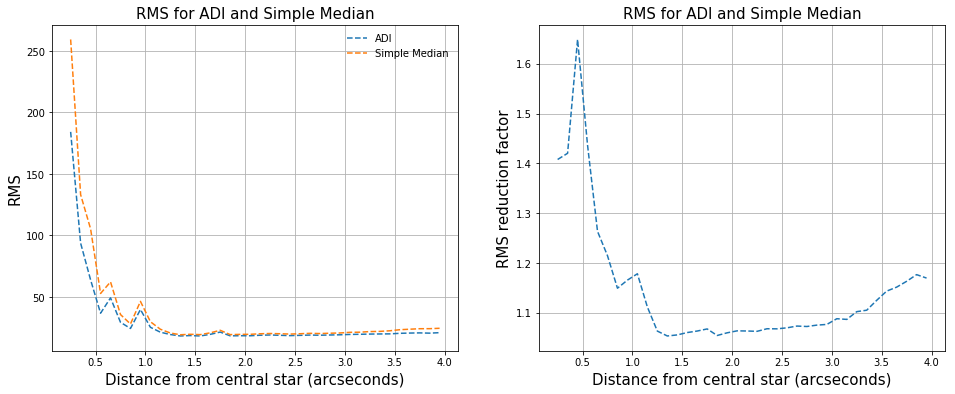

In [16]:
# Q7 answer

Inner  = np.arange(0.2, 4.0, 0.1)
Center = Inner + 0.05

RMSADI = []
RMSSimpleMedian = []

for i in Inner:
    
    maskInner = (r_arcsec > i)
    maskOuter = (r_arcsec < i + 0.1)
    maskAnnulus = (maskInner * maskOuter)
    
    RMSADI.append(np.std(im_ADI_median[maskAnnulus] - np.mean(im_ADI_median[maskAnnulus])))
    RMSSimpleMedian.append(np.std(Median_Derot_2[maskAnnulus] - np.mean(Median_Derot_2[maskAnnulus])))

RMSADI          = np.array(RMSADI)
RMSSimpleMedian = np.array(RMSSimpleMedian)
RMSRatio        = RMSSimpleMedian / RMSADI

fig, ((axA, axB)) = plt.subplots(figsize = (16, 6), nrows = 1, ncols = 2)

axA.plot(Center, RMSADI, '--', label = "ADI")
axA.plot(Center, RMSSimpleMedian, '--', label = "Simple Median")
axA.set_xlabel("Distance from central star (arcseconds)", size = 15)
axA.set_ylabel("RMS", size = 15)
axA.set_title("RMS for ADI and Simple Median", size = 15)
axA.legend(frameon = False)
axA.grid()

axB.plot(Center, RMSRatio, '--')
axB.set_xlabel("Distance from central star (arcseconds)", size = 15)
axB.set_ylabel("RMS reduction factor", size = 15)
axB.set_title("RMS for ADI and Simple Median", size = 15)
axB.grid()

print ("ADI is better at the annulus centered at", Center[np.argmax(RMSRatio)], "arcseconds.")
print ("ADI decreases the RMS there by a factor of", np.amax(RMSRatio), ".")

** DO NOT SEND YOUT FITS CUBES BACK! ONLY THIS JUPYTER NOTEBOOK! **